This notebook prepares the (already annotated) climbing hold detections for tf lite training:  
* XML to dataframe
* Viewing the data
* gcloud data prep - dataframe to formatted csv including train, validation, test split
      ** version 1 - labels are hold types
      ** version 2 - one label - hold

In [1]:
import pandas as pd
import os
from glob import glob
from skimage import io
import matplotlib.pyplot as plt
from matplotlib import patches 
import numpy as np
import random
import subprocess

## XML to Dataframe

In [2]:
path_raw_dir = 'thesis_raw_data'

In [3]:
# Get all images - paths and names

path_imgs = sorted(glob(os.path.join(path_raw_dir,'*.jpg')))
name_imgs = [os.path.basename(p)[:-4] for p in path_imgs]

len(path_imgs), name_imgs[0]

(150, '0001')

In [4]:
# Check if all labels exist
for n in name_imgs:
    if not os.path.exists(os.path.join(path_raw_dir,f'{n}.txt')):
        print(f'{n} missing txt')
    if not os.path.exists(os.path.join(path_raw_dir,f'{n}.xml')):
        print(f'{n} missing xml')

In [5]:
## create dataframe from xmls

df = pd.DataFrame()

for n in name_imgs:
    df1 = pd.read_xml(os.path.join(path_raw_dir,f'{n}.xml'), xpath=".//object")
    df2 = pd.read_xml(os.path.join(path_raw_dir,f'{n}.xml'), xpath=".//bndbox")
    if df1.shape[0]!=df2.shape[0]:
        print(f'{n} missing data - creates mismatch within row')
    df12 = pd.concat((df1,df2), axis=1)
    
    # add image name to all rows
    df12["image"] = n
    # add image size to all rows
    df_size = pd.read_xml(os.path.join(path_raw_dir,f'{n}.xml'), xpath=".//size")
    df12["width"] = df_size.at[0,"width"]
    df12["height"] = df_size.at[0,"height"]
    
    df = pd.concat((df,df12))

In [6]:
df.head(2)

,name,pose,truncated,difficult,bndbox,xmin,ymin,xmax,ymax,image,width,height
0,Sloper,Unspecified,0,0,NaN,269,291,399,362,0001,874,480
1,Sloper,Unspecified,0,0,NaN,518,180,576,227,0001,874,480


In [7]:
df.tail(2)

,name,pose,truncated,difficult,bndbox,xmin,ymin,xmax,ymax,image,width,height
16,Sloper,Unspecified,0,0,NaN,51,353,103,395,0150,400,400
17,Sloper,Unspecified,1,0,NaN,22,368,70,400,0150,400,400


In [8]:
# check if can delete columns
df.pose.unique(), df.difficult.unique(), df.bndbox.unique()

(array(['Unspecified'], dtype=object), array([0]), array([nan]))

In [9]:
# delete columns with one unique value
df = df.drop(["pose","difficult","bndbox"], axis=1)

df = df.reset_index(drop=True)

#reorder columns
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

In [10]:
df.tail()

,height,name,truncated,xmin,ymin,xmax,ymax,image,width
4261,400,Crimps,0,215,109,247,132,0150,400
4262,400,Jugs,1,1,31,24,78,0150,400
4263,400,Pinches,1,1,175,36,218,0150,400
4264,400,Sloper,0,51,353,103,395,0150,400
4265,400,Sloper,1,22,368,70,400,0150,400


## View example data

In [13]:
n2_images = 3

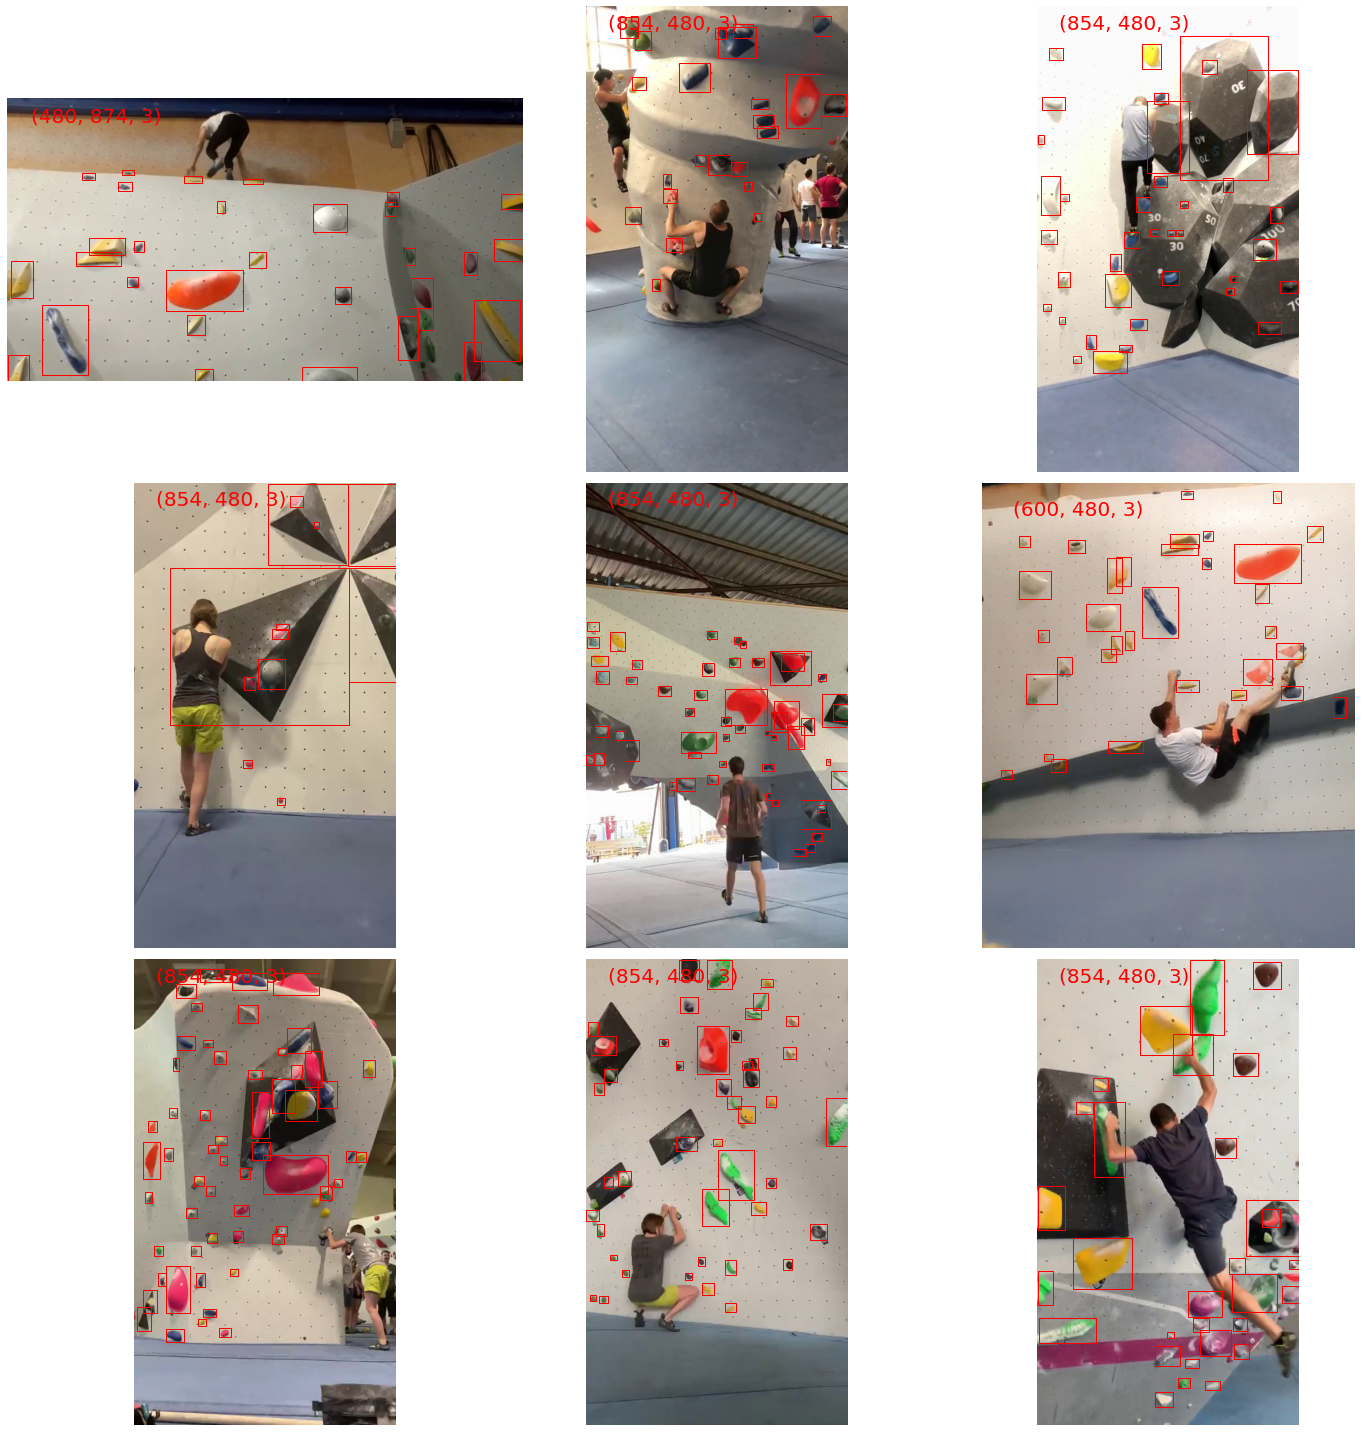

In [15]:
fig,ax = plt.subplots(n2_images,n2_images,figsize=(20,20))
for i in range(n2_images):
    for j in range(n2_images):
        
        curr = (i*n2_images)+j
        img = io.imread(path_imgs[curr])
        df_img = df[df.image==name_imgs[curr]]
        
        ax[i,j].imshow(img)
        ax[i,j].text(40,40, img.shape, color='red', size=20)
        ax[i,j].axis('off')
        
        for ii in df_img.index:
            rect = patches.Rectangle((df.at[ii,"xmin"], df.at[ii,"ymin"]), 
                                     df.at[ii,"xmax"]-df.at[ii,"xmin"], df.at[ii,"ymax"]-df.at[ii,"ymin"], 
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax[i,j].add_patch(rect)
plt.tight_layout()

In [16]:
## Volumes are sometimes annotated and sometimes not!!

## google cloud

uploaded images to google cloud: https://console.cloud.google.com/vision/

In [17]:
# DONE

## change gcloud storage images names to include only original image names.

# files = subprocess.check_output("gsutil ls gs://climbing_holds/0*.jpg",shell=True).decode("utf-8")
# files = files.split("\n")[:-1]

# for f in files:
#     cmd_str = f'gsutil mv {f} {f.split("-2022-")[0]}.jpg'
#     subprocess.call(cmd_str,shell=True)


### prepare csv

#### csv format instructions

https://cloud.google.com/vision/automl/object-detection/docs/prepare  
https://cloud.google.com/vision/automl/object-detection/docs/csv-format

Format:  
set,path,label,x_min,y_min,,,x_max,y_max,,

example:  
TRAINING,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Salad,0.0,0.0954,,,0.977,0.957,,  
VALIDATION,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Seafood,0.0154,0.1538,,,1.0,0.802,,  
TEST,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Tomato,0.0,0.655,,,0.231,0.839,,  

Bounding boxes are specified for each image using the top left and bottom right vertices:  
    (0,0) corresponds to the top left-most vertex.  
    (1,1) corresponds to the bottom right-most vertex.


If you do not specify it, AutoML Vision Object Detection will randomly split your data. Splits are created in the following manner:  
    80% of images are used for training.  
    10% of images are used for hyper-parameter tuning and/or to decide when to stop training.  
    10% of images are used for evaluating the model. These images are not used in training.  


Training images: These images are used to train the object detection model to recognize salad ingredients.  
Validation images: These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid overfitting.  
Test images: These images are used to evaluate the final model performance.  


In [18]:
df.tail(2)

,height,name,truncated,xmin,ymin,xmax,ymax,image,width
4264,400,Sloper,0,51,353,103,395,0150,400
4265,400,Sloper,1,22,368,70,400,0150,400


In [19]:
## create train, validation, test split:

# assuming that val and test are the same size
train_share = 0.8

n_train = int(train_share*len(name_imgs))
n_val = int((len(name_imgs) - n_train)/2)

name_imgs_shuffled = name_imgs[:]
random.Random(42).shuffle(name_imgs_shuffled)

train_imgs = name_imgs_shuffled[:n_train]
val_imgs = name_imgs_shuffled[n_train: n_train+n_val] 
test_imgs = name_imgs_shuffled[n_train+n_val:]

# check unique:
print(set(train_imgs).intersection(set(val_imgs)), 
      set(val_imgs).intersection(set(test_imgs)), 
      set(train_imgs).intersection(set(test_imgs)))

len(train_imgs), len(val_imgs), len(test_imgs)

set() set() set()


(120, 15, 15)

In [20]:
## add set value to df:

df.loc[df.image.isin(train_imgs), "set"] = 'TRAIN'
df.loc[df.image.isin(val_imgs), "set"] = 'VALIDATION'
df.loc[df.image.isin(test_imgs), "set"] = 'TEST'

len(df[df.set=='TRAIN']), len(df[df.set=='VALIDATION']), len(df[df.set=='TEST'])

(3286, 418, 562)

In [21]:
# add path to df
df["path"] = 'gs://climbing_holds/' + df.image.astype(str) + '.jpg'

df.head(2)

,height,name,truncated,xmin,ymin,xmax,ymax,image,width,set,path
0,480,Sloper,0,269,291,399,362,0001,874,TRAIN,gs://climbing_holds/0001.jpg
1,480,Sloper,0,518,180,576,227,0001,874,TRAIN,gs://climbing_holds/0001.jpg


In [22]:
df = df.rename(columns={"name": "label"})
df.head(2)

,height,label,truncated,xmin,ymin,xmax,ymax,image,width,set,path
0,480,Sloper,0,269,291,399,362,0001,874,TRAIN,gs://climbing_holds/0001.jpg
1,480,Sloper,0,518,180,576,227,0001,874,TRAIN,gs://climbing_holds/0001.jpg


In [23]:
## add bounding box formated to xmin/img_size..
# x corresponds to width, y with height 

df['x_min'] = df.xmin/df.width
df['y_min'] = df.ymin/df.height

df['x_max'] = df.xmax/df.width
df['y_max'] = df.ymax/df.height

In [24]:
df["empty0"] = ''
df["empty1"] = ''
df["empty2"] = ''
df["empty3"] = ''

In [25]:
df.head(2)

,height,label,truncated,xmin,ymin,xmax,ymax,image,width,set,path,x_min,y_min,x_max,y_max,empty0,empty1,empty2,empty3
0,480,Sloper,0,269,291,399,362,0001,874,TRAIN,gs://climbing_holds/0001.jpg,0.307780,0.60625,0.456522,0.754167,,,,
1,480,Sloper,0,518,180,576,227,0001,874,TRAIN,gs://climbing_holds/0001.jpg,0.592677,0.37500,0.659039,0.472917,,,,


In [26]:
##Format:
##set,path,label,x_min,y_min,,,x_max,y_max,,

df = df.drop(["image","truncated","height","width","xmin","ymin","xmax","ymax"], axis=1)

In [27]:
#reorder columns
cols = df.columns.tolist()

cols = cols[1:2] + cols[2:3] + cols[0:1] + cols[3:5] + cols[7:9] + cols[5:7] + cols[9:]
df = df[cols]

In [28]:
df.head(3)

,set,path,label,x_min,y_min,empty0,empty1,x_max,y_max,empty2,empty3
0,TRAIN,gs://climbing_holds/0001.jpg,Sloper,0.307780,0.60625,,,0.456522,0.754167,,
1,TRAIN,gs://climbing_holds/0001.jpg,Sloper,0.592677,0.37500,,,0.659039,0.472917,,
2,TRAIN,gs://climbing_holds/0001.jpg,Sloper,0.635011,0.66875,,,0.667048,0.727083,,


In [29]:
df.to_csv('training_climbing_hall_holdTypeLabels.csv', index=False)

In [31]:
df["label"] = 'climbing_hold'

In [32]:
df.head(3)

,set,path,label,x_min,y_min,empty0,empty1,x_max,y_max,empty2,empty3
0,TRAIN,gs://climbing_holds/0001.jpg,climbing_hold,0.307780,0.60625,,,0.456522,0.754167,,
1,TRAIN,gs://climbing_holds/0001.jpg,climbing_hold,0.592677,0.37500,,,0.659039,0.472917,,
2,TRAIN,gs://climbing_holds/0001.jpg,climbing_hold,0.635011,0.66875,,,0.667048,0.727083,,


In [33]:
df.to_csv('training_climbing_hall_sameLabelAllHolds.csv', index=False)

uploaded csv to google cloud, and added it to dataset in: https://console.cloud.google.com/vision/